# MLops project - Lung segmentation

Autoencoders can also be trained for image segmentation. Segmentation means separating specific objects in the image from the background. In practice, this usually comes down to coloring the relevant object in the image. Image segmentation finds its application in self-driving cars, video surveillance and medical imaging. The goal of this assignment is to segment lungs from X-ray images.


Pictures of the lungs can be found in the 'Lung_images' folder.

In this case, the labels are mask images indicating the exact location of the lungs in the image. These masks can be found in the 'Lung_masks' folder.


- Read the images and resize them to the same dimension. For example to 400x400 pixels. A lower resolution is also allowed if you notice that the system requirements are not sufficient. For this application you can convert the images to grayscale.

- Create a training set and test set. Put 20 images in the test set.

- Train a convolutional autoencoder on the training set. The output layer must have the same dimension as the mask images. The autoencoder is then trained to generate a mask based on a long scan that approximates the ground truth mask as closely as possible. However we'll need to use a custom loss function. In fact, cross-entropy based loss functions are not always the best option. In practice, the dice coefficient loss is often used. This loss function looks at the overlap between two data samples. In this case how much the mask generated by the autoencoder overlaps with the ground truth mask. You have to pass this dice loss as a custom loss fuction to the neural network.

```Python
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

```  

Test the auto encoder on the test set. Visualize the generated mask and compare with the actual mask. Try to improve the segmentation via hyperparameter tuning. Use the dice coefficient as a metric in addition to visual inspection.

 U-net is a widely used neural network for medical image segmentation. An implementation can be found here: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277. Implement, train and test this network. Also use the dice coefficient loss as the (custom) loss function. Discuss the results.
 

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.34.0


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

mlops-lungs-segmentation	westeurope	mlops-home-grp_8


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'mlops-lung-segmentation'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. You will submit Python code to run on this VM later in the tutorial. 
The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target: cpu-cluster


### Reading dataset

In [5]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '31701647-d61e-4ee8-a1ae-e4fc5d71e6f6'
resource_group = 'MLOps-Home-Grp_8'
workspace_name = 'mlops-lungs-segmentation'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='dataset')
# dataset.download(target_path='.', overwrite=False)

In [17]:
import cv2 
import os 
import glob 
import random

Lung_images_path = glob.glob("./Lung_images/*.png*") 
Lung_masks_path = glob.glob("./Lung_masks/*.png*") 

def read_images(path):
    images = []
    for f in path: 
        img = cv2.imread(f) 
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(im_rgb, (400,400))
        images.append(resize) 
    return images

X = np.array(read_images(Lung_images_path))
y = np.array(read_images(Lung_masks_path))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_train[0].shape)

(684, 400, 400)
(20, 400, 400)
(400, 400)


In [20]:
# normalisatie van de pixel waarden
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

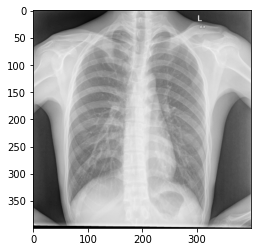

In [21]:
# plotting images
plt.figure()
plt.imshow(X_train[0], cmap="gray")
plt.show()

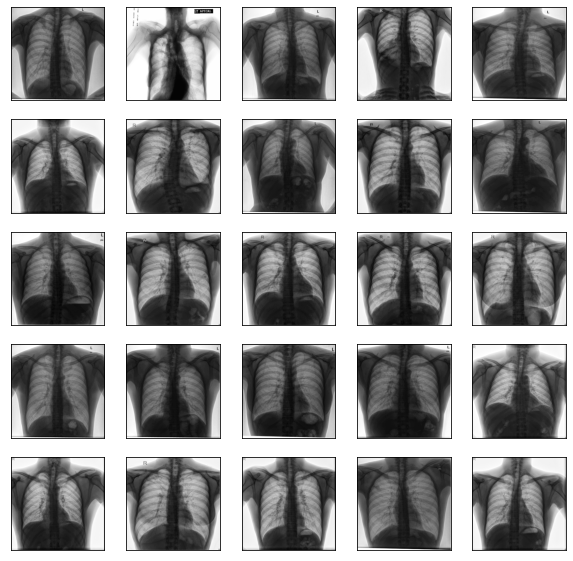

In [22]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

## Train on a remote cluster

For this task, you submit the job to run on the remote training cluster you set up earlier.  To submit a job you:
* Create a directory
* Create a training script
* Create a script run configuration
* Submit the job 

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.

In [23]:
import os
script_folder = os.path.join(os.getcwd(), "mlops-lung-segmentation")
os.makedirs(script_folder, exist_ok=True)

### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called `train.py` in the directory you just created. 

In [ ]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob

import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
# X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
# X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
# y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
# y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)


# Model


# Predicties

print('Predict the test set')
y_hat = model.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')